# Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import chi2

from tqdm import tqdm, trange
import random

import matplotlib.pyplot as plt
import pickle
import statsmodels.api as sm
from scipy.special import expit, logit

# Hyperparameters:

In [2]:
pop_size = 100 * 1_000
sample_size = 30
agg_iters = 1000_0

beta = 1

## for biased sampling mechanism:
sample_probability_centering = 0.8
sample_probability_bias_factor = 1

In [3]:
## for rng generator:
pop_number = 1

# Run:

In [4]:
rand_generator = np.random.default_rng(seed=333 * pop_number)

In [5]:
assert pop_size % 100 == 0
base_x = [i for i in range(-50, 0)] + [i for i in range(1, 51)]
x = pd.Series(base_x * (pop_size // 100))
# normal_stdev = 10
normal_stdev = 30

In [6]:
fitted_betas = []
fitted_FI = []
fitted_correlations = []
realized_sample_sizes = []

Create the simulated data (x, y):

In [7]:
y = x * beta + rand_generator.normal(size=pop_size) * normal_stdev

In [8]:
std_y = np.sqrt(np.var(x) + normal_stdev ** 2)

In [9]:
np.std(y)

42.042984795959725

In [10]:
data = pd.concat([y, x], axis=1)

data.columns = ['y', 'x']

fitted_beta = sm.OLS(data['y'], data['x']).fit().params.iloc[0]

sm.OLS(data['y'], data['x']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.486
Model:                            OLS   Adj. R-squared (uncentered):              0.486
Method:                 Least Squares   F-statistic:                          9.460e+04
Date:                Wed, 01 Jan 2025   Prob (F-statistic):                        0.00
Time:                        15:26:38   Log-Likelihood:                     -4.8247e+05
No. Observations:              100000   AIC:                                  9.649e+05
Df Residuals:                   99999   BIC:                                  9.650e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              1.0005      0.003    307.572      0.000       0.994       1.007
==============================================================================
Omnibus:                        6.615   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.037   Jarque-Bera (JB):                6.474
Skew:                           0.008   Prob(JB):                       0.0393
Kurtosis:                       2.964   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [11]:
data['g_star'] = data['x'] * (data['y'] - data['x'] * fitted_beta)

In [12]:
marginal_probabilities = expit(logit(sample_probability_centering) + \
                               sample_probability_bias_factor * (y / std_y))

In [13]:
np.mean(marginal_probabilities)

0.760300109470481

# run:

In [14]:
for _ in tqdm(range(agg_iters)):
    srs_sample_indices = pd.Series(random.sample(range(pop_size), sample_size))
    srs_sample_indices = srs_sample_indices.sort_values().reset_index(drop=True)

    # reset the sample
    data['r0'] = 0
    data['r'] = 0
    data['r1'] = 0
    data['r2'] = 0
    
    data.loc[srs_sample_indices, 'r0'] = 1
    full_sampled_data = data[data['r0'] == 1]

    # marginal_probabilities = expit(logit(sample_probability_centering) + \
    #                                sample_probability_bias_factor * (full_sampled_data['x'].abs() - 25.5))
    biased_sample_indices = marginal_probabilities.index[rand_generator.binomial(n=1, p = marginal_probabilities) == 1]

    data.loc[biased_sample_indices, 'r'] = 1

    biased_sample_indices_size = len(biased_sample_indices)
    realized_sample_sizes.append(biased_sample_indices_size)


    srs_sample = data[data['r0'] == 1].copy()
    biased_sample = data[data['r'] == 1].copy()

    srs_fitted_beta = sm.OLS(srs_sample['y'], srs_sample['x']).fit().params.iloc[0]
    biased_fitted_beta = sm.OLS(biased_sample['y'], biased_sample['x']).fit().params.iloc[0]

    fitted_betas.append(pd.Series([fitted_beta, srs_fitted_beta, biased_fitted_beta]))

    fitted_FI.append(pd.Series([np.mean(srs_sample['x'] ** 2), np.mean(biased_sample['x'] ** 2)]))

    fitted_correlations.append(data[['g_star', 'r0', 'r']].corr().iloc[0, 1:])

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:30<00:00, 30.26it/s]


Clean up the data:

In [15]:
fitted_betas = pd.concat(fitted_betas, axis=1).T
fitted_FI = pd.concat(fitted_FI, axis=1).T
fitted_correlations = pd.concat(fitted_correlations, axis=1).T.reset_index(drop=True)

In [16]:
fitted_FI.columns = ['srs', 'biased']
fitted_betas.columns = ['population', 'srs', 'biased']
fitted_correlations.columns = ['srs', 'biased']

In [17]:
realized_sample_sizes = pd.Series(realized_sample_sizes)

In [18]:
fitted_FI.head()

,srs,biased
0,819.166667,845.643528
1,869.966667,843.379366
2,662.433333,843.463103
3,792.800000,841.925560
4,860.633333,843.166152


In [19]:
fitted_FI.tail()

,srs,biased
9995,886.166667,843.601574
9996,834.966667,843.243056
9997,815.966667,843.560272
9998,931.200000,843.811090
9999,752.400000,842.550830


# Plot:

In [20]:
fitted_FI_and_corr = fitted_FI.join(fitted_correlations, lsuffix = '_fi', rsuffix = '_corr')

fitted_FI_and_corr.head()

,srs_fi,biased_fi,srs_corr,biased_corr
0,819.166667,845.643528,0.001685,-0.079726
1,869.966667,843.379366,-0.000241,-0.076616
2,662.433333,843.463103,-0.000721,-0.078689
3,792.800000,841.925560,-0.000255,-0.081295
4,860.633333,843.166152,0.010601,-0.076856


In [21]:
Jeee = np.mean(data['x'] ** 2)

fitted_FI_and_corr['srs_samp_elasticity'] = fitted_FI_and_corr.eval(f'srs_fi / {Jeee}')
fitted_FI_and_corr['biased_samp_elasticity'] = fitted_FI_and_corr.eval(f'biased_fi / {Jeee}')

In [22]:
fitted_FI_and_corr.to_pickle('sample_by_y_bias.pkl')

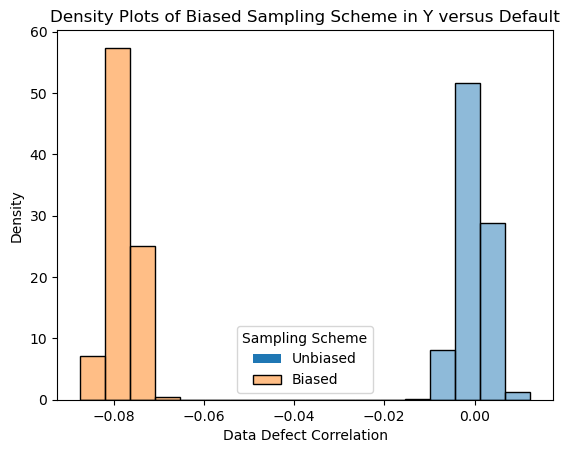

In [23]:
fig = sns.histplot(fitted_FI_and_corr[['srs_corr', 'biased_corr']], stat='density')
plt.xlabel('Data Defect Correlation')
plt.ylabel('Density')
plt.legend(title="Sampling Scheme", labels=["Unbiased", "Biased"])
plt.title('Density Plots of Biased Sampling Scheme in Y versus Default') 
plt.savefig('ddc_densities_y_bias.png', bbox_inches = 'tight')

In [29]:
fitted_FI_and_corr[['srs_fi', 'biased_fi']].describe()

,srs_fi,biased_fi
count,10000.000000,10000.000000
mean,857.656240,858.300860
std,139.719692,1.203012
min,384.733333,853.491356
25%,760.600000,857.479248
50%,855.083333,858.286901
75%,951.133333,859.124714
max,1419.166667,863.062711


Text(0.5, 0.01, 'Jn (across sampling mechanisms)')

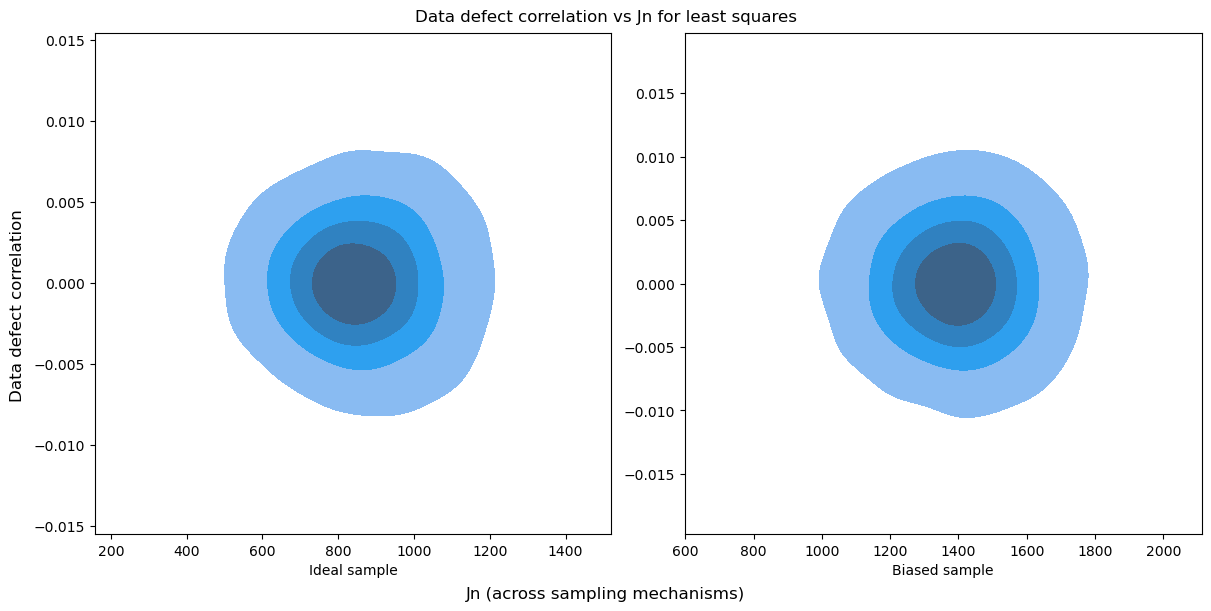

In [21]:
fig, axes = plt.subplots(1, 2, 
                         constrained_layout=True, 
                         figsize=(12, 6))

ax = axes[0]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'srs_fi',
            y = f'srs_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Ideal sample')
ax.set_ylabel('')

ax = axes[1]
sns.kdeplot(data = fitted_FI_and_corr, 
            x=f'biased_fi',
            y = f'biased_corr', 
            fill=True, 
            bw_adjust=1.8, 
            levels=5,
            ax=ax
           )
ax.set_xlabel('Biased sample')
ax.set_ylabel('')

fig.suptitle('Data defect correlation vs Jn for least squares')
fig.supylabel('Data defect correlation')
fig.supxlabel('Jn (across sampling mechanisms)')

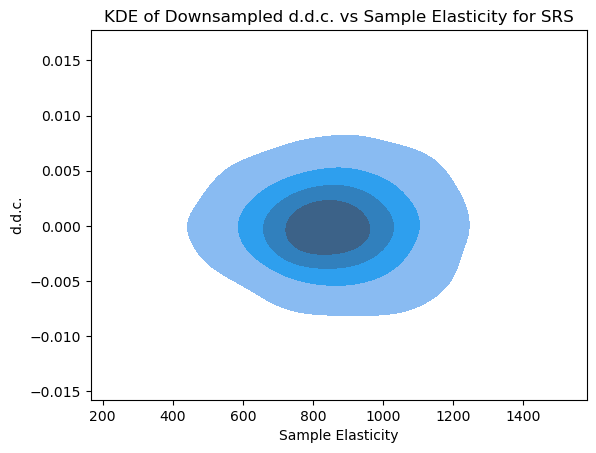

In [110]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'{beta1_name}_fi', \
            y = f'{beta1_name}_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for SRS')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_srs_ols_pop_fixed.png', bbox_inches = 'tight')

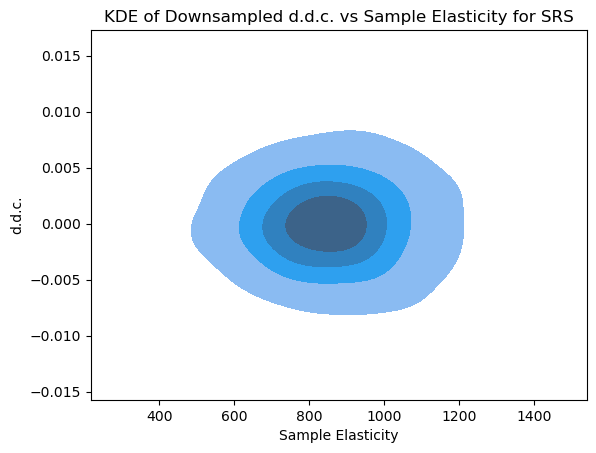

In [112]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'srs_fi', \
            y = f'srs_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for SRS')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_srs_ols_pop_fixed_upper_level.png', bbox_inches = 'tight')

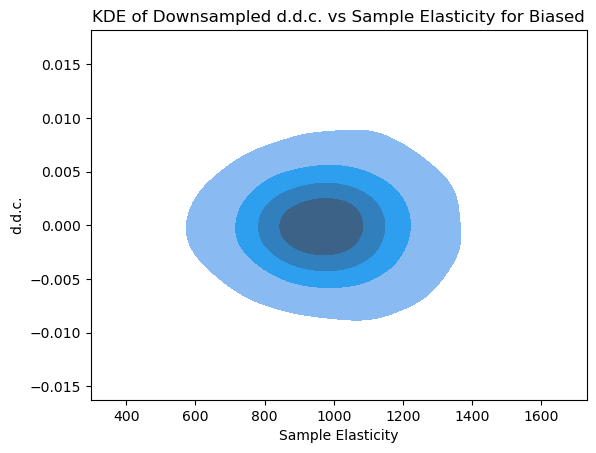

In [111]:
sns.kdeplot(data = fitted_FI_and_corr[::10], x=f'{beta2_name}_fi', \
            y = f'{beta2_name}_corr', fill=True, bw_adjust=1.8, levels=5)
plt.title('KDE of Downsampled d.d.c. vs Sample Elasticity for Biased')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig('kde_downsampled_ddc_vs_sample_elasticity_biased_ols_pop_fixed.png', bbox_inches = 'tight')